# Cluster LVs
This notebook will analyze the latent variables learned by MousiPLIER to see if any studies in the training data have strong clusters in LV space 

In [10]:
import math
import os
import pickle as pkl

import biomart
import numpy as np
import pandas as pd
import pyreadr
from tqdm import tqdm


In [2]:
# From mousiplier's transform.py
class PlierTransform():                                                         
    def __init__(self, weight_file: str, lambda_file: str, debug: bool = False):
        """                                                                     
        Load the PLIER weights into a numpy array                               
                                                                                
        Arguments                                                               
        ---------                                                               
        weight_file: The path to the file output by PLIER storing the weights. By default it will
                     be called Z.tsv                                            
        lambda_file: The file containing the L2 norm used by PLIER for training 
        debug: A flag that prints more information about the input data when set to True
        """                                                                     
        lv_df = pd.read_csv(weight_file, sep='\t')                              
        with open(lambda_file) as in_file:                                      
            self.l2 = float(in_file.readline().strip())                         
        self.lv_df = lv_df                                                      
        loadings = lv_df.to_numpy()                                             
        self.loadings = loadings                                                
        self.file = weight_file                                                 
        self.genes = list(lv_df.index)                                          
                                                                                
        assert len(self.genes) == loadings.shape[0]                             
                                                                                
        if debug:                                                               
            print('Loading values:')                                            
            print(loadings)                                                     
            print('Loadings shape: {}'.format(loadings.shape))                  
            sparsity = (loadings.size - np.count_nonzero(loadings)) / loadings.size
            print('Loadings sparsity = {}'.format(sparsity))                    
                                                                                
            self.loadings = loadings                                            
                                                                                
    def transform(self, expression: pd.DataFrame) -> pd.DataFrame:              
        """                                                                     
        Transform a samples x genes matrix into the PLIER latent space (a samples x LVs matrix)
                                                                                
        Arguments                                                               
        ---------                                                               
        expression: A dataframe containing the rpkm-normalized expression data where the rows are
                    samples and the columns are genes in the same format as the PLIER genes
                                                                                
        Returns                                                                 
        -------                                                                 
        plier_expression: A dataframe where the rows are samples and the columns are latent
                         variables                                              
        """                                                                     
        reordered_expression = expression[list(self.genes)]                     
                                                                                
        # Ensure there aren't multiple columns with the same gene               
        dup_columns = reordered_expression.columns.duplicated()                 
        reordered_expression = reordered_expression.loc[:, ~dup_columns]        
                                                                                
        # Ensure the same number of genes are present in the loadings and expression
        try:                                                                    
            assert reordered_expression.shape[1] == self.loadings.shape[0]      
        except AssertionError as e:                                             
            print('Expression dims: {}'.format(reordered_expression.shape))     
            print('Loading dims: {}'.format(self.loadings.shape))               
            raise e                                                             
                                                                                
        expression_matrix = reordered_expression.values                         
                                                                                
        xTx = self.loadings.T @ self.loadings                                   
        inv_term = np.linalg.inv(xTx + np.identity(self.loadings.shape[1]) * self.l2)
        transformed_matrix = expression_matrix @ self.loadings @ inv_term       
                                                                                
        col_names = ['LV{}'.format(i+1) for i in range(transformed_matrix.shape[1])]
                                                                                
        transformed_df = pd.DataFrame(transformed_matrix, index=reordered_expression.index,
                                      columns=col_names)                        
                                                                                
        return transformed_df                                                   
                                                                                
    def __str__(self):                                                          
        """                                                                     
        Creates a human readable string representation to work with `print`.    
        """                                                                     
        rep = 'PlierTransform object from {}:\n{}\n'.format(self.file, self.loadings)
        rep += 'First and last genes: {}'.format((self.genes[0], self.genes[-1]))
        return rep                               

## Load Data

In [3]:
# Load LVs
transformer = PlierTransform('raw/filtered_Z.tsv', 'raw/filtered_lambda.txt')

In [4]:
# Load expression data in LV space
if not os.path.exists('raw/sample_to_lv.pkl'):
    # This is the code originally used to create sample_to_lv.pkl.
    # The file no_scrna_rpkm.tsv is the preprocessed training data for mousiplier,
    # But was too large to be easily stored via Git 
    expression_file = 'raw/no_scrna_rpkm.tsv'
    line_count = 0
    with open(expression_file, 'r') as in_file:
        for line in in_file:
            line_count += 1

    # Input data is too large to store in memory in expression space, 
    # but it will fit in LV space
    lv_dfs = []

    NUM_SLICES = 10

    for i in tqdm(range(NUM_SLICES)):
        nrows = math.ceil(line_count / NUM_SLICES)
        # Always read the header row by starting skip at row 1
        skiprows = range(1, i * nrows)
        data_df = pd.read_csv(expression_file, sep='\t', header=0, skiprows=skiprows, nrows=nrows)
        sample_ids = data_df['sample']
        transformed_df = transformer.transform(data_df)
        transformed_df['sample'] = sample_ids
        lv_dfs.append(transformed_df)
    lv_df = pd.concat(lv_dfs)
    lv_df = lv_df.set_index('sample')
    
    with open('raw/sample_to_lv.pkl', 'wb') as out_file:
        pkl.dump(lv_df, out_file)
else:
    with open('raw/sample_to_lv.pkl', 'rb') as in_file:
        lv_df = pkl.load(in_file)

## Create gene_signature_participation
The relevant file, 'filtered_Z.tsv' is generated by training a PLIER model and running the mousiplier script `plier_result_stats.R` on the resulting .RDA file

In [5]:
gene_signature_df = pd.read_csv('raw/filtered_Z.tsv', sep='\t')
# Name index
gene_signature_df.index = gene_signature_df.index.rename('GeneID')
# Rename V in columns to LV
gene_signature_df.columns = [c.replace('V', 'LV') for c in gene_signature_df.columns]

gene_signature_df

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV187,LV188,LV189,LV190,LV191,LV192,LV193,LV194,LV195,LV196
GeneID,,,,,,,,,,,,,,,,,,,,,
Xkr4,0.418424,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.423093,0.042285,...,0.0,0.000000,0.000000,0.000000,0.000000,0.068020,0.000000,0.000000,0.105522,0.018134
Sox17,0.066755,0.000000,0.000000,0.043832,0.0,0.077045,0.000000,0.000000,0.411219,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.069582,0.405313,0.000000,0.554926,0.063694
Mrpl15,0.000000,0.161422,0.000000,0.000000,0.0,0.000000,0.529273,0.261089,0.000000,0.000000,...,0.0,0.000000,0.000000,0.055649,0.000000,0.000000,0.061494,0.000000,0.390100,0.318513
Lypla1,0.000000,1.293385,0.000000,0.000000,0.0,0.000000,0.248106,1.191465,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,2.649591,0.047238,0.000000,0.050128,0.000000,0.448619
Tcea1,0.000000,0.000000,0.051854,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tlr8,0.069545,0.000000,0.243067,2.193764,0.0,0.000000,0.050566,0.000000,0.000000,0.000000,...,0.0,0.000000,0.036908,0.000000,0.000000,0.061335,0.000000,0.000000,0.000000,0.000000
Tlr7,0.000000,0.000000,0.839739,1.761074,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.040577,0.000000,0.000000,0.000000,0.000000
Msl3,0.000000,0.013691,0.000000,0.103793,0.0,0.023448,0.007759,0.000000,0.017503,0.000000,...,0.0,0.000000,0.023138,0.000000,0.004023,0.000000,0.008690,0.016135,0.000000,0.082173


In [6]:
gene_signature_df.to_csv('mousiplier_gene_signature_participations.tsv', sep='\t', float_format='%.5f')

## Create sample signature activity

In [8]:
dedup_df = lv_df.reset_index()
dedup_df = dedup_df.drop_duplicates(subset='sample')
dedup_df = dedup_df.set_index('sample')
dedup_df.to_csv('mousiplier_sample_signature_activity.tsv', sep='\t', float_format='%.5f')

## Create gene_gene_network

In [9]:
corr_df = gene_signature_df.T
correlations = corr_df.corr()
correlations.index.name = None

In [10]:
correlations

GeneID,Xkr4,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,St18,Pcmtd1,Vcpip1,...,Ofd1,Trappc2,Rab9,Egfl6,Tmsb4x,Tlr8,Tlr7,Msl3,Amelx,Uty
Xkr4,1.000000,-0.031792,-0.021007,-0.066362,-0.033793,0.133033,0.367476,0.159263,0.321644,0.301972,...,-0.007701,-0.014271,-0.034851,-0.030973,-0.047186,-0.046614,-0.056635,-0.045246,-0.027951,0.101063
Sox17,-0.031792,1.000000,-0.001999,-0.044693,-0.029316,-0.028020,-0.040879,-0.029650,0.073417,-0.043698,...,-0.030564,-0.032777,-0.027300,0.027887,0.001491,-0.036065,-0.044070,-0.032640,0.023958,-0.028272
Mrpl15,-0.021007,-0.001999,1.000000,0.340056,0.507872,-0.037977,0.140363,-0.048316,0.108797,0.011969,...,0.044584,-0.032240,0.081803,-0.024556,-0.047866,-0.041992,-0.060667,-0.025517,-0.035428,0.030730
Lypla1,-0.066362,-0.044693,0.340056,1.000000,0.413139,-0.056440,0.254205,-0.038330,0.317342,0.142868,...,-0.017560,-0.000526,0.034190,-0.036425,-0.017346,-0.048001,-0.068615,0.005437,-0.040394,0.099088
Tcea1,-0.033793,-0.029316,0.507872,0.413139,1.000000,-0.016179,0.309578,0.008099,0.220878,0.344616,...,0.146663,0.095124,0.061457,-0.017976,-0.017971,-0.039779,-0.055701,0.084992,-0.031290,0.028537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tlr8,-0.046614,-0.036065,-0.041992,-0.048001,-0.039779,-0.057060,0.096143,-0.012421,-0.050609,0.096675,...,0.225225,0.134236,0.281827,0.008542,0.379573,1.000000,0.734274,0.328594,-0.027472,0.206508
Tlr7,-0.056635,-0.044070,-0.060667,-0.068615,-0.055701,-0.062409,0.001697,-0.029649,-0.054076,0.172308,...,0.226885,0.133039,0.285330,0.000027,0.375631,0.734274,1.000000,0.311062,-0.040859,0.198965
Msl3,-0.045246,-0.032640,-0.025517,0.005437,0.084992,-0.048638,-0.010219,-0.032702,-0.023366,-0.013532,...,0.792324,0.616772,0.873012,0.105619,0.502247,0.328594,0.311062,1.000000,-0.027023,0.639154
Amelx,-0.027951,0.023958,-0.035428,-0.040394,-0.031290,-0.030101,-0.048884,-0.018982,0.007691,-0.045911,...,-0.037034,-0.031941,-0.032430,0.103696,-0.059850,-0.027472,-0.040859,-0.027023,1.000000,-0.040419


In [11]:
#https://stackoverflow.com/questions/34417685/melt-the-upper-triangular-matrix-of-a-pandas-dataframe
correlations = correlations.where(np.triu(np.ones(correlations.shape)).astype(np.bool))
correlations = correlations.stack().reset_index()
correlations.columns = ['From','To','Correlation']

/home/heil/anaconda3/envs/mousiplier/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [12]:
filtered_correlations = correlations[correlations['From'] != correlations['To']]
filtered_correlations = filtered_correlations[filtered_correlations['Correlation'].abs() > .2]
filtered_correlations

,From,To,Correlation
6,Xkr4,Atp6v1h,0.367476
8,Xkr4,Pcmtd1,0.321644
9,Xkr4,Vcpip1,0.301972
13,Xkr4,A830018L16Rik,0.795730
15,Xkr4,Ncoa2,0.226856
...,...,...,...
61710481,Tlr8,Tlr7,0.734274
61710482,Tlr8,Msl3,0.328594
61710484,Tlr8,Uty,0.206508
61710486,Tlr7,Msl3,0.311062


In [13]:
correlations['Correlation'].min()

-0.18577370117594216

<AxesSubplot:>

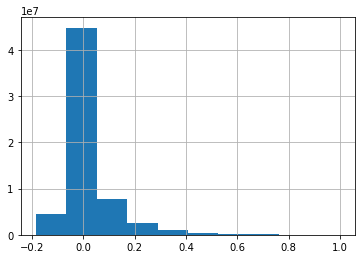

In [14]:
correlations['Correlation'].hist()

In [15]:
with open('mousiplier_gene_gene_network_cutoff_0.2.txt', 'w') as out_file:
    out_file.write('from\tto\tweight\tsign\n')
    for _, row in filtered_correlations.iterrows():
        from_gene, to_gene, correlation = row
        
        weight = abs(correlation)
        sign = '-'
        if correlation > 0:
            sign = '+'
        
        out_file.write('{}\t{}\t{:.4f}\t{}\n'.format(from_gene, to_gene, weight, sign))

## Create gene history file

In [16]:
%%bash

wget ftp://ftp.ncbi.nih.gov/gene/DATA/gene_history.gz                                                                                                                                                    
gunzip -k gene_history.gz  
mv gene_history.gz raw/
(head -1 gene_history; grep  $'^10090\t' gene_history) > gene_history_10090
rm gene_history

--2022-10-12 11:10:09--  ftp://ftp.ncbi.nih.gov/gene/DATA/gene_history.gz
           => ‘gene_history.gz’
Resolving ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)... 130.14.250.11, 130.14.250.10, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)|130.14.250.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gene/DATA ... done.
==> SIZE gene_history.gz ... 126850562
==> PASV ... done.    ==> RETR gene_history.gz ... done.
Length: 126850562 (121M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  762K 2m42s
    50K .......... .......... .......... .......... ..........  0% 5.29M 93s
   100K .......... .......... .......... .......... ..........  0% 40.8M 63s
   150K .......... .......... .......... .......... ..........  0% 5.97M 52s
   200K .......... .......... .......... .......... ..........  0% 43.1M 42s
   250K .......... .......... .......... ...

## Get gene aliases

In [17]:
%%bash

wget http://www.informatics.jax.org/downloads/reports/MRK_List1.rpt -O raw/mouse_gene_annotations.tsv

--2022-10-12 11:10:16--  http://www.informatics.jax.org/downloads/reports/MRK_List1.rpt
Resolving www.informatics.jax.org (www.informatics.jax.org)... 64.147.54.32
Connecting to www.informatics.jax.org (www.informatics.jax.org)|64.147.54.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88176608 (84M)
Saving to: ‘raw/mouse_gene_annotations.tsv’

     0K .......... .......... .......... .......... ..........  0% 1.11M 76s
    50K .......... .......... .......... .......... ..........  0% 1.82M 61s
   100K .......... .......... .......... .......... ..........  0% 42.8M 41s
   150K .......... .......... .......... .......... ..........  0% 41.5M 31s
   200K .......... .......... .......... .......... ..........  0% 2.13M 33s
   250K .......... .......... .......... .......... ..........  0% 40.4M 28s
   300K .......... .......... .......... .......... ..........  0% 41.6M 24s
   350K .......... .......... .......... .......... ..........  0% 40.6M 21s
   400K ..

In [21]:
%%bash 

wget ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Mus_musculus.gene_info.gz -O raw/Mus_musculus.gene_info.gz
gunzip raw/Mus_musculus.gene_info.gz
mv raw/Mus_musculus.gene_info .

URL transformed to HTTPS due to an HSTS policy
--2022-10-12 13:07:46--  https://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Mus_musculus.gene_info.gz
Resolving ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)... 165.112.9.230, 130.14.250.7, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3322115 (3.2M) [application/x-gzip]
Saving to: ‘raw/Mus_musculus.gene_info.gz’

     0K .......... .......... .......... .......... ..........  1% 2.52M 1s
    50K .......... .......... .......... .......... ..........  3% 5.32M 1s
   100K .......... .......... .......... .......... ..........  4% 11.5M 1s
   150K .......... .......... .......... .......... ..........  6% 6.21M 1s
   200K .......... .......... .......... .......... ..........  7% 42.6M 1s
   250K .......... .......... .......... .......... ..........  9% 43.1M 0s
   300K .......... .......... .......... .......... .......... 10% 17

## Filter gene info/history

In [7]:
history_df = pd.read_csv('gene_history_10090', sep='\t')
history_df

,#tax_id,GeneID,Discontinued_GeneID,Discontinued_Symbol,Discontinue_Date
0,10090,320632,9996,BC011390,20050507
1,10090,50518,11286,a,20050510
2,10090,112131,11288,Aaiq1,20050510
3,10090,107417,11289,Aap,20050510
4,10090,112132,11293,Aaiq2,20050510
...,...,...,...,...,...
139257,10090,102639308,115490429,LOC115490429,20200924
139258,10090,-,115490444,LOC115490444,20200924
139259,10090,-,118568312,LOC118568312,20201105
139260,10090,115489542,118568486,LOC118568486,20201107


In [18]:
server = biomart.BiomartServer('http://uswest.ensembl.org/biomart')         
mart = server.datasets['mmusculus_gene_ensembl']

KeyError: 'mmusculus_gene_entrez'

In [26]:
attributes = ['mgi_symbol', 'entrezgene_id']

In [27]:
# Get the mapping between the attributes                                                                                                                                                                
response = mart.search({'attributes': attributes})                                                                                                                                                      
data = response.raw.data.decode('ascii')                                                                                                                                                                

In [33]:
entrez_to_genesymbol = {}                                                                                                                                                                              
# Store the data in a dict                                                                                                                                                                              
for line in data.splitlines():   
    line = line.split('\t')                                                                                                                                                                             
    # The entries are in the same order as in the `attributes` variable                                                                                                                                 
    gene_symbol = line[0]                                                                                                                                                                               
    entrez_id = line[1]                                                                                                                                                                              

    # Some of these keys may be an empty string. If you want, you can
    # avoid having a '' key in your dict by ensuring the
    # transcript/gene/peptide ids have a nonzero length before
    # adding them to the dict
    if len(entrez_id) > 0 and len(gene_symbol) > 0:
        entrez_to_genesymbol[entrez_id] = gene_symbol

In [35]:
print(len(entrez_to_genesymbol))

27336


In [36]:
history_df['UpdatedSymbol'] = history_df['GeneID'].map(entrez_to_genesymbol)
history_df

,#tax_id,GeneID,Discontinued_GeneID,Discontinued_Symbol,Discontinue_Date,UpdatedSymbol
0,10090,320632,9996,BC011390,20050507,Snrnp200
1,10090,50518,11286,a,20050510,Gm14226
2,10090,112131,11288,Aaiq1,20050510,NaN
3,10090,107417,11289,Aap,20050510,NaN
4,10090,112132,11293,Aaiq2,20050510,NaN
...,...,...,...,...,...,...
139257,10090,102639308,115490429,LOC115490429,20200924,NaN
139258,10090,-,115490444,LOC115490444,20200924,NaN
139259,10090,-,118568312,LOC118568312,20201105,NaN
139260,10090,115489542,118568486,LOC118568486,20201107,NaN


In [37]:
history_df.dropna()

,#tax_id,GeneID,Discontinued_GeneID,Discontinued_Symbol,Discontinue_Date,UpdatedSymbol
0,10090,320632,9996,BC011390,20050507,Snrnp200
1,10090,50518,11286,a,20050510,Gm14226
8,10090,227290,11297,Aamp,20050510,Aamp
9,10090,20249,11299,ab,20050510,Scd1
11,10090,20700,11301,Aat2,20050510,Serpina1a
...,...,...,...,...,...,...
139232,10090,637515,115489409,LOC115489409,20200924,Nlrp1b
139235,10090,115487915,115489412,LOC115489412,20200924,Gm23444
139236,10090,637515,115489413,LOC115489413,20200927,Nlrp1b
139238,10090,115487915,115489416,LOC115489416,20200924,Gm23444


In [38]:
mousiplier_genes = set(gene_signature_df.index)
filtered_history = history_df[history_df['UpdatedSymbol'].isin(mousiplier_genes)]
filtered_history

,#tax_id,GeneID,Discontinued_GeneID,Discontinued_Symbol,Discontinue_Date,UpdatedSymbol
0,10090,320632,9996,BC011390,20050507,Snrnp200
8,10090,227290,11297,Aamp,20050510,Aamp
9,10090,20249,11299,ab,20050510,Scd1
12,10090,329165,11349,Abi2,20050510,Abi2
13,10090,226251,11351,Ablim1,20050503,Ablim1
...,...,...,...,...,...,...
139133,10090,16638,115486444,LOC115486444,20200924,Klra7
139154,10090,217708,115487945,LOC115487945,20200924,Lin52
139162,10090,20354,115488166,LOC115488166,20200208,Sema4d
139217,10090,378425,115489386,LOC115489386,20200927,Nlrp12


In [41]:
filtered_history = filtered_history[['#tax_id', 'GeneID', 'Discontinued_GeneID', 'Discontinued_Symbol', 'Discontinue_Date']]
filtered_history.to_csv('filtered_history_10090', sep='\t', index=False)

### Gene info

In [42]:
gene_info_df = pd.read_csv('Mus_musculus.gene_info', sep='\t')
gene_info_df

,#tax_id,GeneID,Symbol,LocusTag,Synonyms,dbXrefs,chromosome,map_location,description,type_of_gene,Symbol_from_nomenclature_authority,Full_name_from_nomenclature_authority,Nomenclature_status,Other_designations,Modification_date,Feature_type
0,10090,11287,Pzp,-,A1m|A2m|MAM,MGI:MGI:87854|Ensembl:ENSMUSG00000030359|Allia...,6,6 F3|6 63.02 cM,"PZP, alpha-2-macroglobulin like",protein-coding,Pzp,"PZP, alpha-2-macroglobulin like",O,pregnancy zone protein|alpha 1 macroglobulin|a...,20220926,-
1,10090,11298,Aanat,-,AA-NAT|Nat-2|Nat4|Snat,MGI:MGI:1328365|Ensembl:ENSMUSG00000020804|All...,11,11 81.43 cM|11 E2,arylalkylamine N-acetyltransferase,protein-coding,Aanat,arylalkylamine N-acetyltransferase,O,serotonin N-acetyltransferase|aralkylamine N-a...,20220926,-
2,10090,11302,Aatk,-,AATYK|aatyk1|mKIAA0641,MGI:MGI:1197518|Ensembl:ENSMUSG00000025375|All...,11,11|11 E2,apoptosis-associated tyrosine kinase,protein-coding,Aatk,apoptosis-associated tyrosine kinase,O,serine/threonine-protein kinase LMTK1|apoptosi...,20220926,-
3,10090,11303,Abca1,-,ABC-1|Abc1,MGI:MGI:99607|Ensembl:ENSMUSG00000015243|Allia...,4,4 B2|4 28.57 cM,"ATP-binding cassette, sub-family A (ABC1), mem...",protein-coding,Abca1,"ATP-binding cassette, sub-family A (ABC1), mem...",O,phospholipid-transporting ATPase ABCA1|ATP-bin...,20220926,-
4,10090,11304,Abca4,-,Abc10|Abcr|D430003I15Rik|RmP,MGI:MGI:109424|Ensembl:ENSMUSG00000028125|Alli...,3,3 G1|3 52.94 cM,"ATP-binding cassette, sub-family A (ABC1), mem...",protein-coding,Abca4,"ATP-binding cassette, sub-family A (ABC1), mem...",O,retinal-specific phospholipid-transporting ATP...,20220926,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73128,57486,3337213,ND3,-,-,-,MT,-,NADH dehydrogenase subunit 3,protein-coding,-,-,-,-,20220830,-
73129,57486,3337214,ND1,-,-,-,MT,-,NADH dehydrogenase subunit 1,protein-coding,-,-,-,-,20220830,-
73130,57486,3337215,ND6,-,-,-,MT,-,NADH dehydrogenase subunit 6,protein-coding,-,-,-,-,20220830,-
73131,57486,3337216,ATP8,-,-,-,MT,-,ATP synthase F0 subunit 8,protein-coding,-,-,-,-,20220830,-


In [45]:
filtered_info_df = gene_info_df[gene_info_df['Symbol'].isin(mousiplier_genes)]
filtered_info_df.to_csv('filtered_Mus_musculus.gene_info', sep='\t', index=False)